# PyCalphad tutorial for molten salts calculations

**pycalphad** is a free and open source software written in Python for performing thermodynamic calculations within the CALculation of PHAse Diagrams (CALPHAD) method.

This tutorial was contributed to by

- Brandon Bocklund (2019, 2020)
- Rushi Gong (2023)

## Outline
1. [Installation](#Installation)
2. [Introduction to pycalphad](#Introduction-to-pycalphad)
3. [Examples](#Examples)



## Installation

### Installing Anaconda

Anaconda is a distribution of the Python programming language and common packages that gives you the tools you need to run and write Python code. This tutorial will only cover the basics of Python needed to do calculations in pycalphad. There are many sources online for learning to write code in python and I encourage you to look at these, and fimiliarize yourself with the language.

[Download Anaconda here](https://www.anaconda.com/download/). 

**Make sure that you select the option to add anaconda to your path variable when installing**

To test that everything installed correctly (Windows):
1. Go to your start menu. You should see several new applications installed
2. Open up the application "Anaconda Prompt", which should open a command window. 
3. Try typing "conda -h" which should print to the screen a help menu of commands for conda.

### Installing pycalphad 

If conda is already installed or you have just completed the installation of Anaconda it is time to install pycalphad. Doing so is easy and fast! 

**pycalphad version >= 0.10.1 works for MQMQA**

See the [pycalphad installation instructions](https://pycalphad.org/docs/latest/INSTALLING.html) for the most up to date instructions.

```
conda create --name pycalphad python==3.9.13
conda activate pycalphad
pip install pycalphad
pip install pydantic==1.10.4
pip install jupyter
jupyter notebook
```

### Access pycalphad through PSU Roar Collab

Anaconda, JupyterLab, and pycalphad have been pre-installed on [PSU Roar Collab](https://www.icds.psu.edu/access-roar-and-roar-collab-online/)

Login Roar Collab [Online portal](https://rcportal.hpc.psu.edu/)

Load anaconda

```
module use /gpfs/group/RISE/sw7/modules
module load anaconda
```

Repeat the previous installation of released version of pycalphad 

Add environment to Jupyter kernel

```
conda activate pycalphad
conda install -c conda-forge ipykernel
ipython kernel install --user --name=pycalphad
```
Load pre-installed environment
```
conda activate /storage/group/RISE/classroom/matse_580
```


## Introduction to pycalphad

In Python you need to import the tools that we use to preform our code. They act as additions to the basic Python language. In general you can copy them as you see here without any modification. At the begining of any new session you must run these import statements to get all the tools we need. if the command below exicutes without any errors, your installation of pycalphad is succesfull.
```python
from pycalphad import Database, equilibrium, calculate, variables as v
from pycalphad.models.model_mqmqa import ModelMQMQA
```

Any calculation in pycalphad requires you to define:

* A Database
* The components to consider
* The phases to consider
* The conditions of the calculation

### Databases

CALPHAD database files are made by researchers who model the Gibbs energy functions. Now pycalphad supports 

* The Thermo-Calc DataBase (TDB) format, usually with the file extension `.tdb`
* The ChemSage database format, usually with the file extension `.dat`
* The XML database format, with the file extension `.xml`

The database can be load in and convert to .xml format through following code

```python
from pycalphad import Database
db = Database("path/to/database.tdb")
db.to_file("path/to/database.xml")
```

### Important notes

* All element and phase names must be capitalized
* Currently, pycalphad take compositions of each element as input
* Output will be normalized in per mol-atom

## Examples

### Equilibrium function in pycalphad

The equilibrium() function is responsible for equilibrium property calculation in pycalphad. The key arguments include
- 'dbf', a database file
- 'comps', a list of desired components
- 'phases', a list of desired phases
- 'conds', a dictionary mapping state variables to values, such as temperature (K), pressure (Pa), compositions, it also can be set as a range with start, stop, and steps forms


equilibrium() output
* Coordinates: input variables, including N, P, T, compositions, component. There is no physical meaning of vertex, this coordinate describe the index of the phase in equilibrium.
* Data variables: output variales
    - NP: Phase fraction, mole fraction of each phase, the index is corresponding to vertex and Phase
    - GM: Gibbs energy of the system, J/mol-atom
    - MU: Chemical potential of each component, the index is corresponding to coordinates component index, unit: J/mol-atom
    - X: The mole fraction of each component in each phase, the phase index is correspoding to vertex, the component index is corresponding to coordinates component index
    - Y: The site fraction of each site in each phase, the phase index is correspoding to vertex, the component index is corresponding to internal degree of freedom
    - Phase: The string name of the phase in equilibrium at the conditions, the index is corresponding to vertex

### Example 1: calculate activity of KCl in KCl-SrCl2 liquid at 1023K

#### Set up the database

KCl-SrCl2 database is took from MSTBD-TC V3.0, the original database is from P. Chartrand & A. D. Pelton, https://doi.org/10.1179/cmq.2000.39.4.405

**Please make sure you have requested the access to MSTDB-TC V3.0 https://code.ornl.gov/neams/mstdb/, the instruction file has been attached, this MSTDB-TC V3.0 xml file is only for tutorial use**

In [193]:
from pycalphad import Database, equilibrium, variables as v
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from pycalphad.models.model_mqmqa import ModelMQMQA
import os

dbf=Database('MSTDB_V3_Cl.xml')
comps = ['K', 'SR', 'CL']
phases = ['MSCL']
#phases = list(dbf.phases.keys()) # a command to automatically read all phases from the database

#### Calculate the reference state
Because all chemical activities must be specified with a reference state, we’re going to choose a reference state which is consistent with the experimental data.

In [194]:
ref_eq = equilibrium(dbf, ['K', 'CL'], 'MSCL', {v.N: 1, v.P: 101325, v.T: 1023, v.X('K'):0.5})

In [195]:
ref_eq

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_K: 1, vertex: 3, component: 2,
                internal_dof: 1)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 1.023e+03
  * X_K        (X_K) float64 0.5
  * vertex     (vertex) int64 0 1 2
  * component  (component) <U2 'CL' 'K'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_K, vertex) float64 1.0 nan nan
    GM         (N, P, T, X_K) float64 -2.749e+05
    MU         (N, P, T, X_K, component) float64 -2.749e+05 -2.749e+05
    X          (N, P, T, X_K, vertex, component) float64 0.5 0.5 nan nan nan nan
    Y          (N, P, T, X_K, vertex, internal_dof) float64 1.0 nan nan
    Phase      (N, P, T, X_K, vertex) <U6 'MSCL' '' ''
Attributes:
    engine:   pycalphad 0.1.dev1893+g7133e49.d20230911
    created:  2023-09-11T19:43:00.422986

#### Calculate the equilibria

Perform the calculation over the composition range

In [196]:
# A simple function to convert mole fraction of SrCl2 to elemental mole fraction
x_Sr=list()
x_K=list()
x_Cl=list()
x_SrCl2=[0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for i in x_SrCl2:
    xsr=i/(i*3+(1-i)*2)
    xk=(1-i)/(i*3+(1-i)*2)
    xcl=(i*2+(1-i))/(i*3+(1-i)*2)
    x_Sr.append(xsr)
    x_K.append(xk)
    x_Cl.append(xcl)

In [197]:
eq = equilibrium(dbf, ['K', 'CL', 'SR'], 'MSCL', {v.N: 1, v.P: 101325, v.T: 1023, v.X('K'): x_K, v.X('SR'): x_Sr})

In [198]:
eq

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 1, X_K: 9, X_SR: 9, vertex: 4, component: 3,
                internal_dof: 3)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 1.023e+03
  * X_K        (X_K) float64 0.4286 0.3636 0.3043 ... 0.1111 0.07143 0.03448
  * X_SR       (X_SR) float64 0.04762 0.09091 0.1304 ... 0.2593 0.2857 0.3103
  * vertex     (vertex) int64 0 1 2 3
  * component  (component) <U2 'CL' 'K' 'SR'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_K, X_SR, vertex) float64 1.0 nan nan ... nan nan nan
    GM         (N, P, T, X_K, X_SR) float64 -2.847e+05 nan ... nan -3.269e+05
    MU         (N, P, T, X_K, X_SR, component) float64 -4.316e+05 ... -1.371e+05
    X          (N, P, T, X_K, X_SR, vertex, component) float64 0.5238 ... nan
    Y          (N, P, T, X_K, X_SR, vertex, internal_dof) float64 0.7874 ... nan
    Phase      (N, P, T, X_K, X_SR, vertex) <U6 'MSCL' '' '' '' ... '' '' ''
Attributes:
    engine:   pycalphad 0.1.dev1893+g7133e49.d20230911
    created:  2023-09-11T19:43:08.665361

In [199]:
chempot_ref = ref_eq.MU.sel(component='K').squeeze()+ref_eq.MU.sel(component='CL').squeeze()
chempot = (eq.MU.sel(component='K').squeeze()+eq.MU.sel(component='CL').squeeze())
acr=np.exp((chempot - chempot_ref)/(8.3145*1023))  # mu=mu_ref+RTln(acr)
KCl_acr=[]
for index in range(0,len(acr)):
    KCl_acr.append(acr[index][index].values)

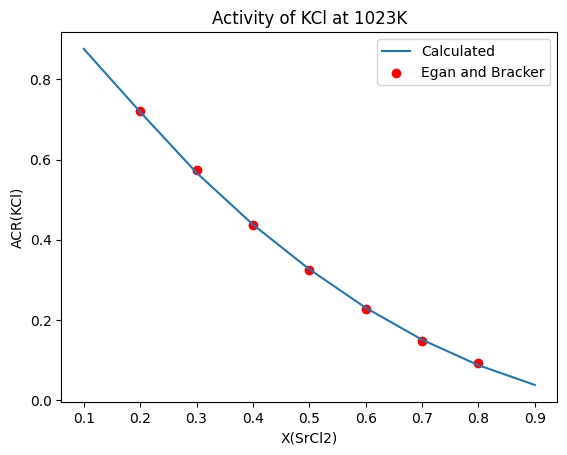

In [113]:
import matplotlib.pyplot as plt
plt.plot(x_SrCl2, KCl_acr, label='Calculated')
# add experimental data from Egan and Bracker, https://doi.org/10.1016/0021-9614(74)90201-8
exp_x_srcl2=[0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
exp_acr_kcl=[0.72, 0.574, 0.436, 0.325, 0.228, 0.147, 0.093]
plt.scatter(exp_x_srcl2, exp_acr_kcl, label='Egan and Bracker', color='red')
plt.xlabel('X(SrCl2)')
plt.ylabel('ACR(KCl)')
plt.title('Activity of KCl at 1023K')
plt.legend(loc=0)
plt.show()

### Example 2: equilibrium property in LiCl-CaCl2-KCl-NaCl-SrCl2-BaCl2

#### Set up calculation conditions

In [209]:
# 0.12LiCl, 0.3CaCl2, 0.15KCl, 0.23NaCl, 0.08SrCl2, 0.12BaCl2, convert these compositions into elemental composition
xLiCl=0.12
xCaCl2=0.3
xKCl=0.15
xNaCl=0.23
xSrCl2=0.08
xBaCl2=0.12
totN=xLiCl*2+xCaCl2*3+xKCl*2+xNaCl*2+xSrCl2*3+xBaCl2*3
xLi=xLiCl/totN
xCa=xCaCl2/totN
xK=xKCl/totN
xNa=xNaCl/totN
xSr=xSrCl2/totN
xBa=xBaCl2/totN
xCl=(xLiCl+xCaCl2*2+xKCl+xNaCl+xSrCl2*2+xBaCl2*2)/totN

In [210]:
# Check the conversion
xLi+xCa+xK+xNa+xSr+xBa+xCl

1.0000000000000002

In [214]:
dbf=Database('MSTDB_V3_Cl.xml')
comps = ['LI', 'CA', 'K', 'NA', 'SR', 'BA', 'CL']
#screen out phases containing desired elements
from pycalphad.core.utils import filter_phases, unpack_components
fcomps=sorted(unpack_components(dbf,comps))
phases=filter_phases(dbf, fcomps)
print(phases)
conds={v.N: 1, v.P: 101325, v.T: (600,1000,10), v.X('LI'): xLi, v.X('CA'): xCa, v.X('K'): xK, v.X('NA'): xNa, v.X('SR'): xSr, v.X('BA'): xBa}

['BACL2_FM3M_NO.225(S2)', 'BACL2_PNMA_NO.62(S)', 'BA_S1(S)', 'CACL2_P42/MNM_NO.136(S2)', 'CACL2_PNNM_NO.58(S)', 'CA_S1(S)', 'CA_S2(S2)', 'FM3M', 'GAS_IDEAL', 'K2BACL4_S1(S)', 'K2SRCL4_S1(S)', 'K3LA5SOLN', 'KCACL3_S1(S)', 'KCL_FM3M_NO.225(S)', 'KSR2CL5_S1(S)', 'K_S1(S)', 'LICL_FM3M_NO.225(S)', 'LI_S1(S)', 'MSCL', 'NACL_FM3M_NO.225(S)', 'NA_S1(S)', 'P42_MN', 'PNNM', 'R3M', 'SRCL2_FM3M_NO.225(S)', 'SRCL2_FM3M_NO.225_(DISO(S2)', 'SR_BCC(S2)', 'SR_FCC(S)']


In [215]:
eq=equilibrium(dbf, comps, phases, conds)
eq

<xarray.Dataset>
Dimensions:    (N: 1, P: 1, T: 40, X_BA: 1, X_CA: 1, X_K: 1, X_LI: 1, X_NA: 1,
                X_SR: 1, vertex: 8, component: 7, internal_dof: 28)
Coordinates:
  * N          (N) float64 1.0
  * P          (P) float64 1.013e+05
  * T          (T) float64 600.0 610.0 620.0 630.0 ... 960.0 970.0 980.0 990.0
  * X_BA       (X_BA) float64 0.048
  * X_CA       (X_CA) float64 0.12
  * X_K        (X_K) float64 0.06
  * X_LI       (X_LI) float64 0.048
  * X_NA       (X_NA) float64 0.092
  * X_SR       (X_SR) float64 0.032
  * vertex     (vertex) int64 0 1 2 3 4 5 6 7
  * component  (component) <U2 'BA' 'CA' 'CL' 'K' 'LI' 'NA' 'SR'
Dimensions without coordinates: internal_dof
Data variables:
    NP         (N, P, T, X_BA, X_CA, X_K, X_LI, X_NA, X_SR, vertex) float64 0...
    GM         (N, P, T, X_BA, X_CA, X_K, X_LI, X_NA, X_SR) float64 -2.731e+0...
    MU         (N, P, T, X_BA, X_CA, X_K, X_LI, X_NA, X_SR, component) float64 ...
    X          (N, P, T, X_BA, X_CA, X_K, X_LI, X_NA, X_SR, vertex, component) float64 ...
    Y          (N, P, T, X_BA, X_CA, X_K, X_LI, X_NA, X_SR, vertex, internal_dof) float64 ...
    Phase      (N, P, T, X_BA, X_CA, X_K, X_LI, X_NA, X_SR, vertex) <U27 'BAC...
Attributes:
    engine:   pycalphad 0.1.dev1893+g7133e49.d20230911
    created:  2023-09-11T19:47:50.779746

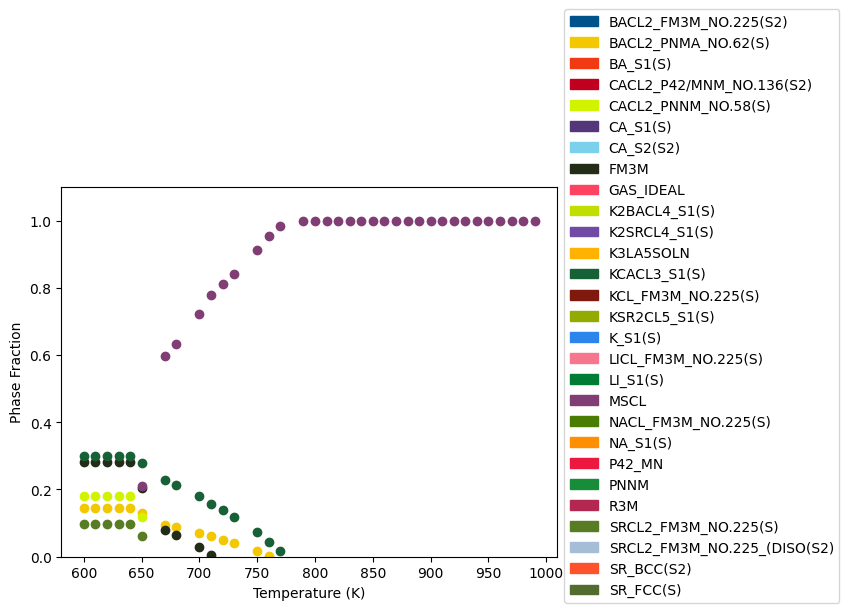

In [217]:
from pycalphad.plot.utils import phase_legend
phase_handles, phasemap = phase_legend(phases)

plt.gca().set_xlabel('Temperature (K)')
plt.gca().set_ylabel('Phase Fraction')
plt.gca().set_ylim((0,1.1))

for name in phases:
    phase_indices = np.nonzero(eq.Phase.values == name)
    plt.scatter(np.take(eq['T'].values, phase_indices[2]), eq.NP.values[phase_indices], color=phasemap[name])
plt.gca().legend(phase_handles, phases, bbox_to_anchor=[1, 1.5])

### Example 3: phase diagram of KCl-SrCl2

In [174]:
"""
Modify eqplot module in pycalphad to plot pesudo-binary, this function only applies to plot pesudo-phase diagram when charge of anions is -1

The eqplot module contains functions for general plotting of
the results of equilibrium calculations.
"""
from pycalphad.core.utils import unpack_condition
from pycalphad.plot.utils import phase_legend
import pycalphad.variables as v
from matplotlib import collections as mc
import matplotlib.pyplot as plt
import numpy as np
from collections import OrderedDict

# TODO: support other state variables here or make isinstance elif == v.T or v.P
_plot_labels = {v.T: 'Temperature (K)', v.P: 'Pressure (Pa)'}


def _axis_label(ax_var):
    if isinstance(ax_var, v.MoleFraction):
        return 'X({})'.format(ax_var.species.name)
    elif isinstance(ax_var, v.StateVariable):
        return _plot_labels[ax_var]
    else:
        return ax_var

def _map_coord_to_variable(coord):
    """
    Map a coordinate to a StateVariable object.

    Parameters
    ----------
    coord : str
        Name of coordinate in equilibrium object.

    Returns
    -------
    pycalphad StateVariable
    """
    vals = {'T': v.T, 'P': v.P}
    if coord.startswith('X_'):
        return v.X(coord[2:])
    elif coord in vals:
        return vals[coord]
    else:
        return coord


def eqplot(eq, ax=None, x=None, y=None, z=None, tielines=True, tieline_color=(0, 1, 0, 1), tie_triangle_color=(1, 0, 0, 1), legend_generator=phase_legend, **kwargs):
    """
    Plot the result of an equilibrium calculation.

    The type of plot is controlled by the degrees of freedom in the equilibrium calculation.

    Parameters
    ----------
    eq : xarray.Dataset
        Result of equilibrium calculation.
    ax : matplotlib.Axes
        Default axes used if not specified.
    x : StateVariable, optional
    y : StateVariable, optional
    z : StateVariable, optional
    tielines : bool
        If True, will plot tielines
    tieline_color: color
        A valid matplotlib color, such as a named color string, hex RGB
        string, or a tuple of RGBA components to set the color of the two
        phase region tielines. The default is an RGBA tuple for green:
        (0, 1, 0, 1).
    tie_triangle_color: color
        A valid matplotlib color, such as a named color string, hex RGB
        string, or a tuple of RGBA components to set the color of the two
        phase region tielines. The default is an RGBA tuple for red:
        (1, 0, 0, 1).
    legend_generator : Callable
        A function that will be called with the list of phases and will
        return legend labels and colors for each phase. By default
        pycalphad.plot.utils.phase_legend is used
    kwargs : kwargs
        Passed to `matplotlib.pyplot.scatter`.

    Returns
    -------
    matplotlib AxesSubplot
    """
    conds = OrderedDict([(_map_coord_to_variable(key), unpack_condition(np.asarray(value)))
                         for key, value in sorted(eq.coords.items(), key=str)
                         if (key in ('T', 'P', 'N')) or (key.startswith('X_'))])
    indep_comps = sorted([key for key, value in conds.items() if isinstance(key, v.MoleFraction) and len(value) > 1], key=str)
    indep_pots = [key for key, value in conds.items() if (type(key) is v.StateVariable) and len(value) > 1]

    # determine what the type of plot will be
    if len(indep_comps) == 1 and len(indep_pots) == 1:
        projection = None
    elif len(indep_comps) == 2 and len(indep_pots) == 0:
        projection = 'triangular'
    else:
        projection = None
    #if z is not None:
    #    raise NotImplementedError('3D plotting is not yet implemented')
    if ax is None:
        fig, (ax) = plt.subplots(subplot_kw={'projection': projection})
    # Handle cases for different plot types
    if projection is None:
        x = indep_comps[0] if x is None else x
        y = indep_pots[0] if y is None else y
        # plot settings
        ax.set_xlim([np.min(conds[x]) - 1e-2, np.max(conds[x]) + 1e-2])
        ax.set_ylim([np.min(conds[y]), np.max(conds[y])])
    elif projection == 'triangular':
        x = indep_comps[0] if x is None else x
        y = indep_comps[1] if y is None else y
        # Here we adjust the x coordinate of the ylabel.
        # We make it reasonably comparable to the position of the xlabel from the xaxis
        # As the figure size gets very large, the label approaches ~0.55 on the yaxis
        # 0.55*cos(60 deg)=0.275, so that is the xcoord we are approaching.
        ax.yaxis.label.set_va('baseline')
        fig_x_size = ax.figure.get_size_inches()[0]
        y_label_offset = 1 / fig_x_size
        ax.yaxis.set_label_coords(x=(0.275 - y_label_offset), y=0.5)

    phases = map(str, sorted(set(np.array(eq.Phase.values.ravel(), dtype='U')) - {''}, key=str))
    comps = map(str, sorted(np.array(eq.coords['component'].values, dtype='U'), key=str))
    eq['component'] = np.array(eq['component'], dtype='U')
    eq['Phase'].values = np.array(eq['Phase'].values, dtype='U')

    # Select all two- and three-phase regions
    three_phase_idx = np.nonzero(np.sum(eq.Phase.values != '', axis=-1, dtype=np.int_) == 3)
    two_phase_idx = np.nonzero(np.sum(eq.Phase.values != '', axis=-1, dtype=np.int_) == 2)

    legend_handles, colorlist = legend_generator(phases)

    # For both two and three phase, cast the tuple of indices to an array and flatten
    # If we found two phase regions:
    if two_phase_idx[0].size > 0:
        found_two_phase = eq.Phase.values[two_phase_idx][..., :2]
        # get tieline endpoint compositions
        two_phase_x = eq.X.sel(component=x.species.name).values[two_phase_idx][..., :2]
        two_phase_z = eq.X.sel(component=z.species.name).values[two_phase_idx][..., :2]
        #print('two_phase_x:', two_phase_x[..., 0])
        # handle special case for potential
        if isinstance(y, v.MoleFraction):
            two_phase_y = eq.X.sel(component=y.species.name).values[two_phase_idx][..., :2]
        else:
            # it's a StateVariable. This must be True
            two_phase_y = np.take(eq[str(y)].values, two_phase_idx[eq.Phase.dims.index(str(y))])

            # because the above gave us a shape of (n,) instead of (n,2) we are going to create it ourselves
            two_phase_y = np.array([two_phase_y, two_phase_y]).swapaxes(0, 1)

        # plot two phase points
        two_phase_plotcolors = np.array(list(map(lambda x: [colorlist[x[0]], colorlist[x[1]]], found_two_phase)), dtype='U')
        ax.scatter(two_phase_x[..., 0]/(two_phase_x[..., 0]+two_phase_z[..., 0]), two_phase_y[..., 0], s=3, c=two_phase_plotcolors[:, 0], edgecolors='None', zorder=2, **kwargs)
        ax.scatter(two_phase_x[..., 1]/(two_phase_x[..., 1]+two_phase_z[..., 1]), two_phase_y[..., 1], s=3, c=two_phase_plotcolors[:, 1], edgecolors='None', zorder=2, **kwargs)
        result1=[two_phase_x[..., 0]/(two_phase_x[..., 0]+two_phase_z[..., 0]), two_phase_y[..., 0], two_phase_x[..., 1]/(two_phase_x[..., 1]+two_phase_z[..., 1]), two_phase_y[..., 1]]
        #np.savetxt('tie-lines.txt', result1)

        if tielines:
            # construct and plot tielines
            two_phase_tielines = np.array([np.concatenate((two_phase_x[..., 0][..., np.newaxis]/(two_phase_x[..., 0][..., np.newaxis]+two_phase_z[..., 0][..., np.newaxis]), two_phase_y[..., 0][..., np.newaxis]), axis=-1),
                                           np.concatenate((two_phase_x[..., 1][..., np.newaxis]/(two_phase_x[..., 1][..., np.newaxis]+two_phase_z[..., 1][..., np.newaxis]), two_phase_y[..., 1][..., np.newaxis]), axis=-1)])
            two_phase_tielines = np.rollaxis(two_phase_tielines, 1)
            lc = mc.LineCollection(two_phase_tielines, zorder=1, colors=tieline_color, linewidths=[0.5, 0.5])
            ax.add_collection(lc)

    # position the phase legend and configure plot
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(handles=legend_handles, loc='center left', bbox_to_anchor=(1, 0.5))
    ax.tick_params(axis='both', which='major', labelsize=14)
    ax.grid(True)
    plot_title = '-'.join([component.title() for component in sorted(comps) if component != 'VA'])
    ax.set_title(plot_title, fontsize=20)
    ax.set_xlabel(_axis_label(x), labelpad=15, fontsize=20)
    ax.set_ylabel(_axis_label(y), fontsize=20)

    return ax


['FM3M', 'GAS_IDEAL', 'K2SRCL4_S1(S)', 'K3LA5SOLN', 'KCL_FM3M_NO.225(S)', 'KSR2CL5_S1(S)', 'K_S1(S)', 'MSCL', 'SRCL2_FM3M_NO.225(S)', 'SRCL2_FM3M_NO.225_(DISO(S2)', 'SR_BCC(S2)', 'SR_FCC(S)']
0 done
1 done
2 done
3 done
4 done
5 done
6 done


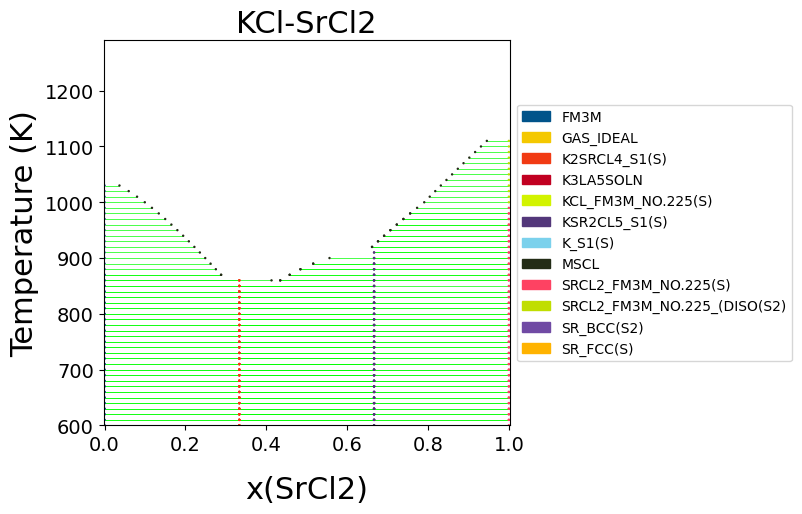

In [179]:
#Plot figure setting
fig= plt.figure(figsize=(25,5))
ax = fig.add_subplot()

#Database and condition setting
dbf = Database('MSTDB_V3_Cl.xml')
comps = ['SR', 'K', 'CL']
x_Sr=list()
x_K=list()
x_SrCl2=[0.02, 0.28, 0.39, 0.528, 0.6, 0.761, 0.96]
for i in x_SrCl2:
    xsr=i/(i*3+(1-i)*2)
    xk=(1-i)/(i*3+(1-i)*2)
    xf=(i*2+(1-i))/(i*3+(1-i)*2)
    x_Sr.append(xsr)
    x_K.append(xk)
    
    
#Filter phases
from pycalphad.core.utils import filter_phases, unpack_components
fcomps=sorted(unpack_components(dbf,comps))
phases=filter_phases(dbf, fcomps)
print(phases)

#Phase legend for plotting
def fixed_phase_legend(phases):
    legend_handles, colorlist = phase_legend(phases)
    def _dummy_phase_legend(_):
        return legend_handles, colorlist
    return _dummy_phase_legend

#Perform equilibrium calcualtions to map the whole compostion space
eq=[]
for i in range(0, len(x_SrCl2)):
    conds = {v.N: 1, v.P: 101325, v.T: (600,1300,10), v.X('K'): x_K[i], v.X('SR'):x_Sr[i]}
    result=equilibrium(dbf, comps, phases, conds, verbose=False)
    eq.append(result)
    print(i, 'done')
    
#Plot phase diagram
phase_leg_func = fixed_phase_legend(phases)
for i in range(0, len(eq)):
    eqplot(eq[i], x=v.X('SR'), y=v.T, z=v.X('K'),legend_generator=phase_leg_func, ax=ax)


ax.set_xlim(-0.0025, 1.0025)
ax.set_xlabel('x(SrCl2)', fontsize=22)
ax.set_ylabel('Temperature (K)', fontsize=22)
ax.set_title('KCl-SrCl2', fontsize=22)
#ax.legend().remove()
plt.grid(False)
plt.savefig('KCl-SrCl2-PD-MSTDB.png', bbox_inches='tight', dpi=300)
plt.show()

Currently, pycalphad does not support plotting of liquidus projection